In [1]:
import pandas as pd
from econometron.Models.dynamicsge import linear_dsge

In [2]:
import numpy as np

In [3]:
# Model setup
equations=[ 
           "- r_t + phi*p_t=0",
           "p_t - beta * p_tp1 - kappa * (x_t - xbar_t) = 0",
           "x_t - x_tp1 + (1/g) * (r_t - p_tp1) = 0",
           "- xbar_tp1 + rho * xbar_t + sigmax = 0"]
variables=[ 'r','p','x','xbar']
states=['xbar']
exo_states=['xbar']
shock=['sigmax']
# Parameters dictionary
parameters = {
    'g': 5,      # Inverse of relative risk aversion (1/g)
    'beta': 0.99,       # Discount factor
    'kappa': 0,
    'rho': 0.95,        # Persistence of output gap target
    'phi': 1.5,         # Taylor rule inflation coefficient
    'd': 0.5,          # Calvo parameter
    'sigmax':0.01
}

In [4]:
sigma_X,beta,g,rho,phi,d=parameters['sigmax'],parameters['beta'],parameters['g'],parameters['rho'],parameters['phi'],parameters['d']
parameters['kappa']=((1-d)*(1-d*beta))/d

In [5]:
new_keynisian_model=linear_dsge(equations=equations,variables=variables,exo_states=exo_states,shocks=shock,parameters=parameters)

In [6]:
initial_guess = [1, 1, 1]
new_keynisian_model.set_initial_guess(initial_guess)

In [7]:
new_keynisian_model.compute_ss(initial_guess,method='fsolve',options={'xtol': 1e-10})

Steady-state residuals: [ 0.   -0.    0.   -0.01]


r        0.000000e+00
p        0.000000e+00
x      -4.940656e-324
xbar     0.000000e+00
dtype: float64

In [8]:
A,B,C=new_keynisian_model.approximate(method='analytical')

In [9]:
new_keynisian_model.solve_RE_model()
print("Policy Function (f):\n", new_keynisian_model.f)
print("State Transition (p):\n", new_keynisian_model.p)

Policy Function (f):
 [[-0.64715933]
 [-0.43143956]
 [ 0.94916702]]
State Transition (p):
 [[0.95]]


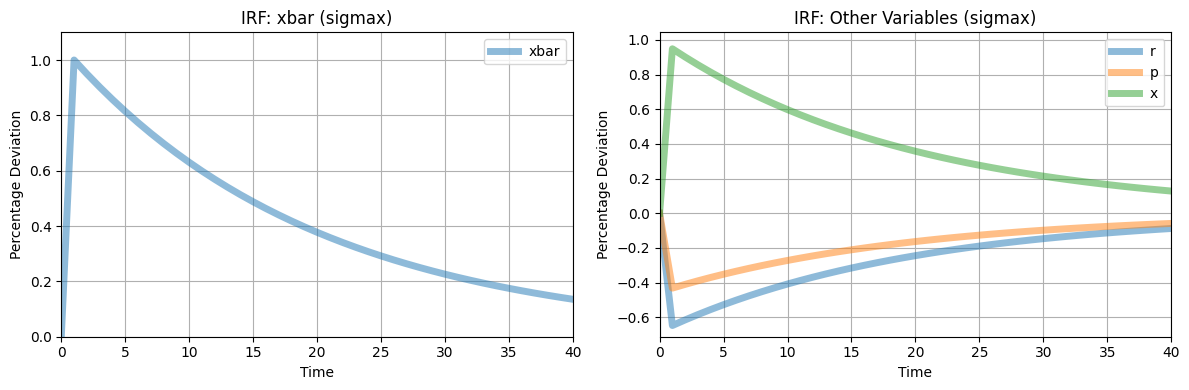

In [10]:
new_keynisian_model.plot_irfs()

In [11]:
new_keynisian_model.simulate(T=100, drop_first=10, covariance_matrix=np.array([[0.01**2]]))

,sigmax_t,r_t,p_t,x_t,xbar_t
0,-0.013826,-0.020657,0.013369,0.008912,-0.019607
1,0.007467,-0.012157,0.007868,0.005245,-0.011539
2,-0.001171,-0.012720,0.008232,0.005488,-0.012073
3,-0.004150,-0.016234,0.010506,0.007004,-0.015409
4,-0.006134,-0.021557,0.013951,0.009300,-0.020461
...,...,...,...,...,...
95,-0.007093,0.001039,-0.000672,-0.000448,0.000986
96,0.003318,0.004305,-0.002786,-0.001857,0.004086
97,-0.020472,-0.016383,0.010602,0.007068,-0.015550
98,-0.010063,-0.025627,0.016585,0.011056,-0.024324


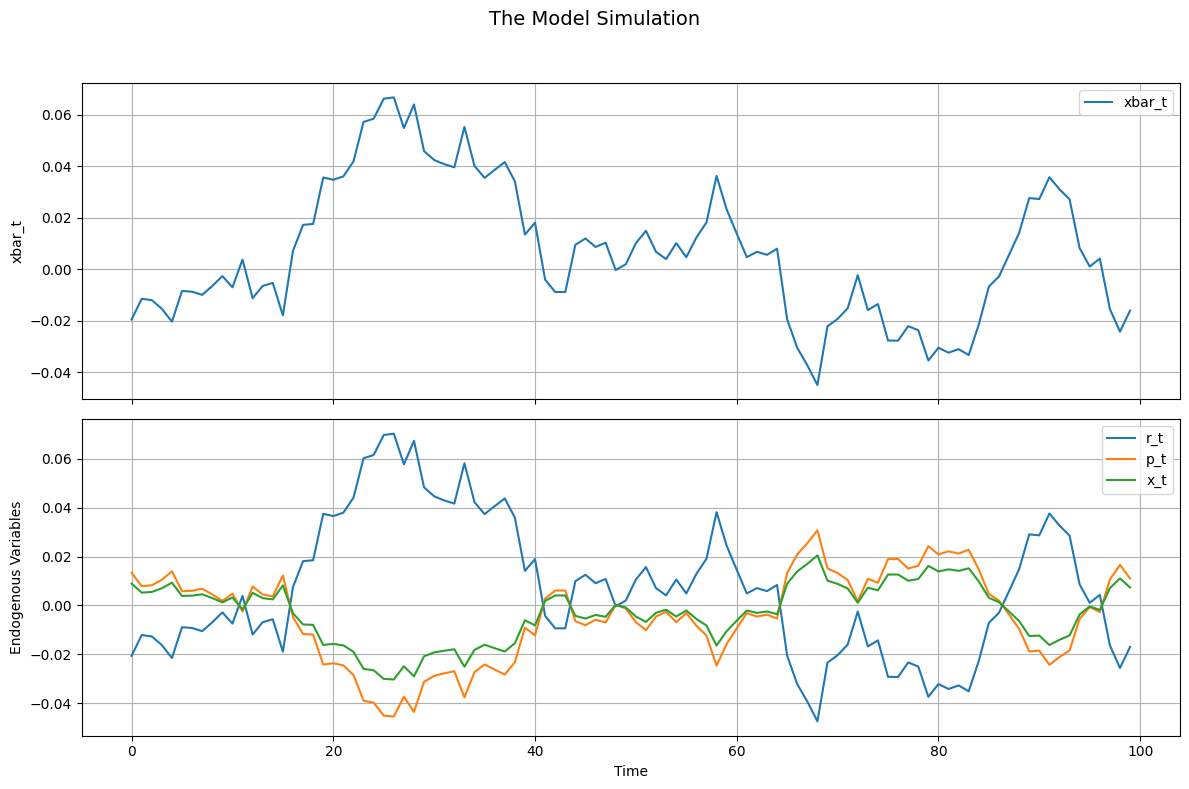

In [12]:
new_keynisian_model.simulations()

In [13]:
from econometron.utils.state_space import update_ss
from econometron.utils.estimation.MLE import simulated_annealing_kalman
from econometron.utils.estimation.Bayesian import rwm_kalman,compute_proposal_sigma,make_prior_function

In [14]:
GDP=pd.read_csv("../../Data_Fred/gdp.csv", index_col=0, parse_dates=True)
Inflation=pd.read_csv("../../Data_Fred/inflation.csv", index_col=0, parse_dates=True)
Interest_Rate=pd.read_csv("../../Data_Fred/int_rate.csv", index_col=0, parse_dates=True)
mac_data = pd.concat([Interest_Rate, Inflation, GDP], axis=1)
mac_data = mac_data.dropna()
# Rename columns for clarity
mac_data.columns = ['Int', 'Inf', 'GDP']
# Apply log transformation01)
mac_data = np.log(mac_data)
# Remove rows with -inf, inf, or NaN values
mac_data = mac_data.replace([np.inf, -np.inf], np.nan).dropna().transpose()
#int for intrest_rate for simplcity

In [15]:
mac_data.isna().sum()

observation_date
1990-01-01    0
1990-04-01    0
1990-07-01    0
1990-10-01    0
1991-01-01    0
             ..
2024-01-01    0
2024-04-01    0
2024-07-01    0
2024-10-01    0
2025-01-01    0
Length: 138, dtype: int64

In [16]:
mac_data.shape

(3, 138)

In [17]:
from econometron.utils.data_preparation import TimeSeriesProcessor

In [18]:
TSP=TimeSeriesProcessor(mac_data.T,method='hodrick_prescott',lamb=1600)

Processing column: Int
  Int final stationarity: True
Processing column: Inf
  Inf is already stationary
Processing column: GDP
  GDP final stationarity: True


In [29]:
trans_data=TSP.get_transformed_data().T.values

In [30]:
trans_data.shape

(3, 138)

In [25]:
def derived_fn(p):
    p['kappa'] = ((1 -p['d']) * (1-p['d']*p['beta']))/p['d']
    return p
#since we have kappa is written in function of Beta nd delta , the derived_fn here is param fixer , for parameter that are not intialized  
def R_builder(p):
  A1 = np.array([[1, -p['phi'], 0],
                    [0, 1, -p['kappa']],
                    [1/p['g'], 0, 1]])
  if abs(np.linalg.det(A1)) < 1e-6:
    raise ValueError("A1 matrix is singular")
  R1= np.array([[p['sigma_r'], 0, 0],
                [0, p['sigma_p'], 0],
                [0, 0, p['sigma_y']]])
  R=np.linalg.solve(A1,R1)
  return R
def C_builder(p):
    return np.array([[p['sigmax']]])

In [26]:
base_params = {
    'g': 1.00000000e+01,
    'beta': 8.97384125e-01,
    'kappa': 0.8,
    'rho': 9.61923424e-01,
    'phi': 1,
    'd': 8.64607398e-01 ,
    'sigmax': 7.52359617e-03,
    'sigma_y': 0.01,
    'sigma_p': 0.01,
    'sigma_r': 0.01
}
# [1.00000000e+01 8.97384125e-01 9.61923424e-01 1.00000000e+00
#  8.64607398e-01 7.52359617e-03 7.20758075e-03 1.00000000e-06
#  9.97050476e-03]
update_state_space = update_ss.make_state_space_updater(
    base_params=base_params,
    solver=new_keynisian_model.solve_RE_model,
    build_R=R_builder,
    build_C=C_builder,
    derived_fn=derived_fn
)

In [31]:
param_names = [k for k in base_params.keys() if k != 'kappa'] # since Kappa is calulated 
initial_params = [base_params[name] for name in param_names]
fixed_params = {} # calibrated models 
LB= [0,0,0,1,0,0,0,0,0]
UB= [10,1,1,5,1,1,1,1,1]

In [32]:
MLE_Results=simulated_annealing_kalman(trans_data,initial_params ,LB, UB, param_names, fixed_params, update_state_space,seed=1,T0=5,rt=0.9,nt=2,ns=2)

[10.0, 0.897384125, 0.961923424, 1, 0.864607398, 0.00752359617, 0.01, 0.01, 0.01]
initial loss function value: 1630977.085554592
[8.34044009405148, 0.897384125, 0.961923424, 1, 0.864607398, 0.00752359617, 0.01, 0.01, 0.01]


UnboundLocalError: local variable 'sa_t' referenced before assignment